# Training parameterized quantum circuits

## Vocab
+ Minimize <phi(theta)|H|phi(theta)> (this is the loss function)
+ Quantum Fisher Information (Natural Gradients)
+ Simultaneous Perturbation Stochastic Approximation

In [1]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear')
# RealAmplitudes -> TwoLocal -> NLocal -> BlueprintCircuit -> QuantumCircuit
print(ansatz.draw())
ansatz = ansatz.decompose()
ansatz.draw()

     ┌──────────────────────────────────────┐
q_0: ┤0                                     ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                                     ├
     └──────────────────────────────────────┘


┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

## Calculate finite difference gradient
### Opflow (deprecated)

In [2]:
import numpy as np
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, Z, I

hamiltonian = Z ^ Z
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    print(result)
    return np.real(result)

print(ansatz.num_parameters)
point = np.random.random(ansatz.num_parameters)
INDEX = 2

EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]
print(e_i)

plus = point + EPS * e_i
minus = point - EPS * e_i

print(plus)
print(minus)

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

C:\Users\vutha\AppData\Local\Temp\ipykernel_24744\3630295614.py:4: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, Z, I
C:\Users\vutha\AppData\Local\Temp\ipykernel_24744\3630295614.py:7: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
C:\Users\vutha\AppData\Local\Temp\ipykernel_24744\3630295614.py:7: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be remo

4
[0. 0. 1. 0.]
[0.06030339 0.51559035 1.12619714 0.11859583]
[0.06030339 0.51559035 0.72619714 0.11859583]
(0.33642578125+0j)
(0.5947265625+0j)
-0.645751953125


C:\Users\vutha\AppData\Local\Temp\ipykernel_24744\3630295614.py:10: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
C:\Users\vutha\AppData\Local\Temp\ipykernel_24744\3630295614.py:14: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  sampler = CircuitSampler(quantum_instance)


### Quantum_info and primitives

Doc on how to use Estimator class: https://qiskit.org/ecosystem/ibm-runtime/stubs/qiskit_ibm_runtime.Estimator.html 

In [3]:
from qiskit.quantum_info import Pauli
from qiskit_aer.primitives import Estimator

hamiltonian = Pauli('ZZ')

estimator = Estimator(run_options={"shots":8192, "seed_simulator":2718})
def evaluate_expectation(theta):
    result = estimator.run(ansatz, hamiltonian, theta).result().values
    # or we can set seed and shot like this 
    # result = estimator.run(ansatz, hamiltonian, theta, run_options={"shots":8192, "seed_simulator":2718}).result().values
    print(result)
    return np.real(result)

point = np.random.random(ansatz.num_parameters)
INDEX = 2

EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]
print(e_i)

plus = point + EPS * e_i
minus = point - EPS * e_i

print(plus)
print(minus)

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

[0. 0. 1. 0.]
[0.76458921 0.03741711 1.11859484 0.14914101]
[0.76458921 0.03741711 0.71859484 0.14914101]
[0.51293945]
[0.80029297]
[-0.71838379]


### Nghich Quantum_info and primitives

In [4]:
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Clifford

X = SparsePauliOp("X")

qc = QuantumCircuit(1)
qc.h(0)
H = Clifford(qc).to_operator()

plus = QuantumCircuit(1)
plus.h(0)

estimator = Estimator()
values_plus = estimator.run([plus, plus], [X, H]).result().values

print(values_plus)

[1.         0.70710678]


## Calculate with Qiskit gradient

### opflow (soon Deprecated)

C:\Users\vutha\AppData\Local\Temp\ipykernel_24744\3727955521.py:3: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)


ansatz params : ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3])])
ansatz params element : θ[2]
grad : SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])
value dict : {ParameterVectorElement(θ[0]): 0.7645892106157126, ParameterVectorElement(θ[1]): 0.0374171081083291, ParameterVectorElement(θ[2]): 0.9185948399337447, ParameterVectorEleme

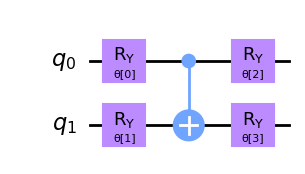

In [12]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)

grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print("ansatz params : %s" % (ansatz.parameters))
print("ansatz params element : %s" % (ansatz.parameters[INDEX]))
print("grad : %s" %(grad)) # grad object contain the info of which param to optimize already

value_dict = dict(zip(ansatz.parameters, point))
print("value dict : %s" % (value_dict))

sampler.convert(grad, value_dict).eval().real

ansatz.bind_parameters([0,0,0,0])
ansatz.draw('mpl') # in order to be displayed correctly it need to be at the end of the line, this is possible thanks to matplotlib_inline
# this doesn't bind the value to the image

### Quantum_info and primitives

In [ ]:
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

grad = ParamShiftEstimatorGradient(estimator)

print(ansatz.draw)
print(ansatz.parameters)
print(hamiltonian)
print(point)

result = grad.run(ansatz, hamiltonian,[point], [ansatz.parameters[INDEX:INDEX+1]]).result()
# Argument parameter of function run:
# parameters: The sequence of parameters to calculate only the gradients of the specified parameters.

gradients = result.gradients
print(gradients)

<bound method QuantumCircuit.draw of <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001AA5F2EF850>>
ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3])])
ZZ
[0.42495457 0.09020963 0.3669372  0.65445027]
[array([-0.03129386])]


## Optimizer 

### opflow

In [ ]:
# initial_point = np.random.random(ansatz.num_parameters)
# Initialize 
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

C:\Users\vutha\AppData\Local\Temp\ipykernel_21404\648942205.py:5: DeprecationWarning: The class ``qiskit.opflow.gradients.gradient.Gradient`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  gradient = Gradient().convert(expectation)
C:\Users\vutha\AppData\Local\Temp\ipykernel_21404\648942205.py:6: DeprecationWarning: The class ``qiskit.opflow.expectations.pauli_expectation.PauliExpectation`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  gradient_in_pauli_basis = PauliExpectation().convert(gradient)
C:\Users\vutha\AppData\Local\Temp\ipykernel_21404\648942205.py:7: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier